This notebook extracts and formats 4 predictor variables (number of working inhabitants, number of college graduates, number of youth (18-24) and number of immigrants) by Parisian district over the period 2006-2016 (last available year). These data come from Insee's IRIS database, which collects several hundreds of variables at the sub-city level. 

We selected four variables that we believe have a strong influence (potentially causal) on the outcome of elections in each district of Paris. Our assumption may be wrong, but it will be easy to see that once we put the data into the model -- it won't run or will tell us that these variables are not correlated with the outcome. The model will use these predictors to try and predict election results in each district, but we'll do that in another notebook. 

Let's start with some import statements and a handy function to extract predictors:

In [1]:
%load_ext lab_black
%load_ext watermark

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from fbprophet import Prophet
from pathlib import Path

repos = ["activite_residents", "diplomes_formation", "population", "population"]
var_codes = ["C_ACTOCC1564", "P_NSCOL15P_SUP", "P_POP1824", "P_POP_IMM"]
var_names = ["actifs_occupes", "college_grad", "youth", "immigration"]

In [2]:
def extract_predictor(repo: str, var_code: str, var_name: str) -> pd.Series:
    """
    Gets all files in the given repo, selects wanted predictor variable, 
    restricts to Paris, extracts the district numbers, aggregates predictor by district,
    and then returns formatted time series
    """
    basepath = Path(f"../../../Downloads/db_iris_all/{repo}/")
    files_in_path = basepath.glob("*.xls")
    print(f"Began extracting {var_name} predictor from {repo} repo...\n")

    # load and concat files (heavy):
    preds = pd.DataFrame()
    for file in files_in_path:
        df = pd.read_excel(
            file,
            header=5,
            sheet_name="IRIS",
            usecols=["DEP", "LIBCOM", f"{var_code[:1]}{file.stem[-2:]}{var_code[1:]}"],
            dtype={"DEP": "category", "LIBCOM": "category"},
            nrows=40_500,
        )
        df = df[df.DEP == "75"].reset_index(drop=True).drop("DEP", axis=1)
        preds = pd.concat([preds, df], axis=1)

    # drop duplicated column values:
    preds = preds.T.drop_duplicates().T
    # drop duplicated column names:
    preds = preds.loc[:, ~preds.columns.duplicated()]

    # extract district number:
    preds["LIBCOM"] = preds.LIBCOM.str.extract("(\d+)").astype(int)
    preds = preds.rename(columns={"LIBCOM": "arrondissement"})

    # aggregate by district and prettify columns:
    preds = preds.groupby("arrondissement").sum()
    preds.columns = preds.columns.str[1:3].astype(int) + 2000
    preds.columns.name = "year"
    preds = preds.sort_index(axis=1)
    preds = preds.stack()
    preds.name = var_name

    print(f"Finished extracting and aggregating {var_name} predictor.\n")
    return preds

The raw excel files where the data live are very heavy, so this function will take some time to run -- but it will be worth it. Indeed, it will go and load the files where each predictor is, for  each year on record, do some formatting and restricting and then return a dataframe with the proper time series. Let's run it and go get a cup of coffee:

In [3]:
predictors = []
for r, c, n in zip(repos, var_codes, var_names):
    predictors.append(extract_predictor(r, c, n))

Began extracting actifs_occupes predictor from activite_residents repo

Finished extracting and aggregating actifs_occupes predictor

Began extracting college_grad predictor from diplomes_formation repo

Finished extracting and aggregating college_grad predictor

Began extracting youth predictor from population repo

Finished extracting and aggregating youth predictor

Began extracting immigration predictor from population repo

Finished extracting and aggregating immigration predictor



In [4]:
predictors = pd.concat(predictors, axis=1)
predictors.to_csv("data/predictors_by_district.csv")
predictors

actifs_occupes  college_grad         youth   immigration
arrondissement year                                                          
1              2006     9485.059228   6453.630949   1874.672223   3148.134542
               2007     9546.148694   6731.105539   1866.646378   3227.921219
               2008     9469.633224   6770.997547   1816.180756   3121.358408
               2009     9665.691628   6994.804860   1842.097989   3121.406343
               2010     9558.180760   7009.239728   1779.033595   3021.113668
...                             ...           ...           ...           ...
20             2012    91753.677270  44244.946169  18234.641207  43045.904247
               2013    90488.610079  63058.398038  18156.671990  42888.160363
               2014    90469.181326  66282.764695  18133.119561  42123.803538
               2015    90370.240523  68786.240273  17977.773858  41633.325845
               2016    90874.227479  71851.173023  17537.759874  41180.244725

[220 rows x 4 columns]

Had a nice coffee? As you can see, we now have the predictors ready to match with past election results, and then to give to the model! Let's do that in another notebook.

## Interpolation (Prophet, TFP.sts, sk-learn)?

In [5]:
df = pd.read_csv(
    "../../../tptm_alex/pm-prophet/examples/example_wp_log_peyton_manning.csv"
)
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [7]:
m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [8]:
forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.206497,7.520836,8.940388
3266,2017-01-16,8.531523,7.801207,9.240534
3267,2017-01-17,8.318930,7.602419,9.080266
3268,2017-01-18,8.151543,7.453595,8.841630
3269,2017-01-19,8.163477,7.420596,8.919746


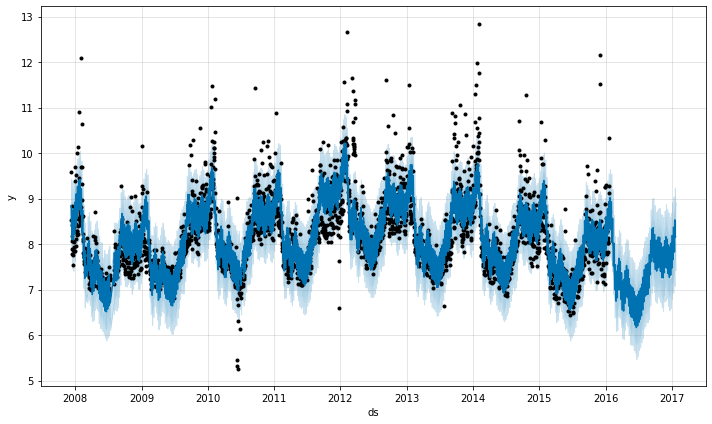

In [9]:
fig1 = m.plot(forecast)

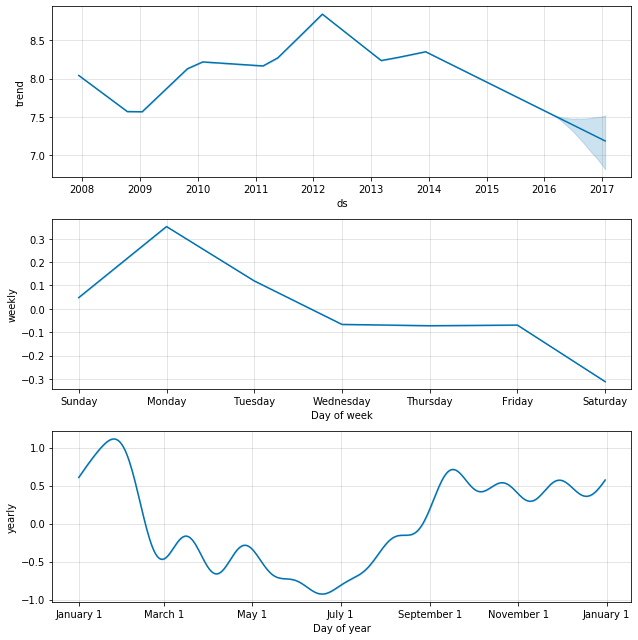

In [10]:
fig2 = m.plot_components(forecast)

In [3]:
predictors = pd.read_csv("data/predictors_by_district.csv").set_index("arrondissement")
predictors["year"] = pd.to_datetime(predictors.year, format="%Y") + pd.DateOffset(
    months=11, days=30
)
predictors

,year,actifs_occupes,college_grad,youth,immigration
arrondissement,,,,,
1,2006-12-31,9485.059228,6453.630949,1874.672223,3148.134542
1,2007-12-31,9546.148694,6731.105539,1866.646378,3227.921219
1,2008-12-31,9469.633224,6770.997547,1816.180756,3121.358408
1,2009-12-31,9665.691628,6994.804860,1842.097989,3121.406343
1,2010-12-31,9558.180760,7009.239728,1779.033595,3021.113668
...,...,...,...,...,...
20,2012-12-31,91753.677270,44244.946169,18234.641207,43045.904247
20,2013-12-31,90488.610079,63058.398038,18156.671990,42888.160363
20,2014-12-31,90469.181326,66282.764695,18133.119561,42123.803538


In [4]:
df = predictors.loc[1, ["year", "actifs_occupes"]].reset_index(drop=True)
df.columns = ["ds", "y"]
df

,ds,y
0,2006-12-31,9485.059228
1,2007-12-31,9546.148694
2,2008-12-31,9469.633224
3,2009-12-31,9665.691628
4,2010-12-31,9558.180760
5,2011-12-31,9453.454849
6,2012-12-31,9110.708956
7,2013-12-31,8883.849949
8,2014-12-31,8438.116225
9,2015-12-31,8135.217082


In [56]:
m = PMProphet(
    df,
    growth=True,
    intercept=True,
    n_changepoints=5,
    changepoints_prior_scale=0.01,
    name="model",
)
m.fit(method='NUTS')

AttributeError: 'str' object has no attribute 'value'